## Predicting whether the student will be recruited or not in campus placements.

The successful placement of students in campus recruitments is important for educational institutions, influencing their reputation, annual admissions and overall growth. This report endeavors to predict whether students will be recruited based on various factors available in the dataset.

### Importing Libraries

In [473]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC

# Suppressing warnings
warnings.filterwarnings('ignore')

### Load the train dataset

In [474]:
df_train = pd.read_csv('./dataset/train.csv')
df_train.head(5)

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,0,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,0,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,0,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,0,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,0,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


In [475]:
df_train.shape

(215, 15)

This rows and columns shows, we have 215 candidates with 15 features.

In [476]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sl_no           215 non-null    int64  
 1   gender          215 non-null    int64  
 2   ssc_p           215 non-null    float64
 3   ssc_b           215 non-null    object 
 4   hsc_p           215 non-null    float64
 5   hsc_b           215 non-null    object 
 6   hsc_s           215 non-null    object 
 7   degree_p        215 non-null    float64
 8   degree_t        215 non-null    object 
 9   workex          215 non-null    object 
 10  etest_p         215 non-null    float64
 11  specialisation  215 non-null    object 
 12  mba_p           215 non-null    float64
 13  status          215 non-null    object 
 14  salary          148 non-null    float64
dtypes: float64(6), int64(2), object(7)
memory usage: 25.3+ KB


We have some missing values in the salary column, which is expected for the candidates who weren't hired.

### Data Cleaning

In handling missing values, impute the values. Since it concerns the <b>salary</b> feature, it's best to impute '0' for the candidates who were not hired.

In [477]:
df_train['salary'].fillna(value=0, inplace=True)

In [478]:
df_train['salary'].isnull().sum()

0

Drop unwanted features:
- sl_no
- ssc_b
- hsc_b

In [479]:
df_train.drop(['sl_no','ssc_b','hsc_b'], axis = 1,inplace=True) 
df_train.head()

,gender,ssc_p,hsc_p,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,0,67.00,91.00,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,0,79.33,78.33,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,0,65.00,68.00,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,0,56.00,52.00,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,0.0
4,0,85.80,73.60,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


In [480]:
df_gender = pd.DataFrame(df_train.groupby(['gender','status'])['status'].count())
df_gender

status
gender status            
0      Not Placed      39
       Placed         100
1      Not Placed      28
       Placed          48

## Exploratory Data Analysis

Out of 215 candidates, 139 are male and 76 are female.

<Axes: xlabel='gender', ylabel='count'>

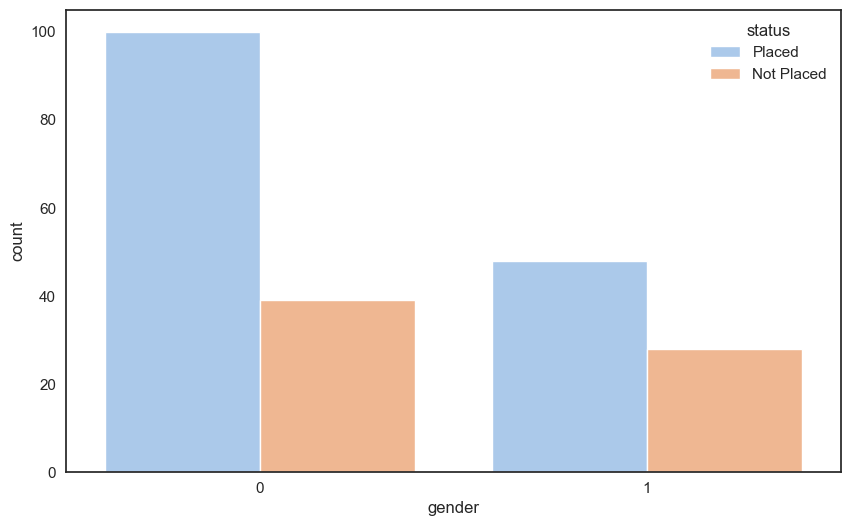

In [481]:
sns.countplot(x='gender', hue='status', data=df_train)

The plot shows a comparison between the number of placed and not placed students across the two gender (Male=0, Female=1) categories.

Distribution Salary by Placed Students

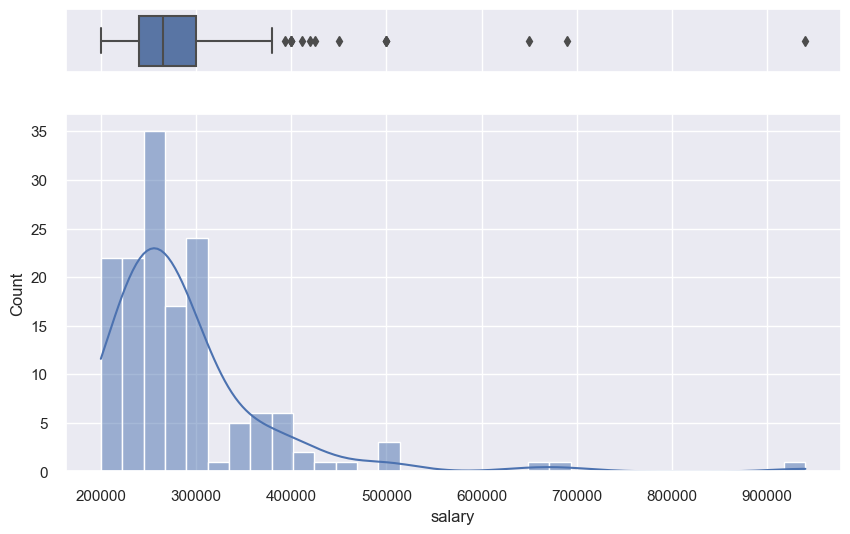

In [482]:
# Set the figure size
sns.set(rc={'figure.figsize': (10,6)})

# Create the subplots with shared x-axis and specified height ratios
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

# Filter the dataset to exclude rows where salary is 0
placement_placed = df_train[df_train.salary != 0]

# Create the boxplot and histogram
sns.boxplot(data=placement_placed, x="salary", ax=ax_box)
sns.histplot(data=placement_placed, x="salary", ax=ax_hist, kde=True)

# Remove x-axis label from the boxplot
ax_box.set(xlabel='')

# Display the plot
plt.show()

The box plot shows the central tendency and spread of the salary data, indicating the presence of several outliers on the higher end.
The histogram shows that the majority of the salaries are clustered between 200,000 and 400,000, with a peak around 250,000.
The plot provides a smooth estimate of the distribution, highlighting a right-skewed distribution with a long tail towards the higher salary values.

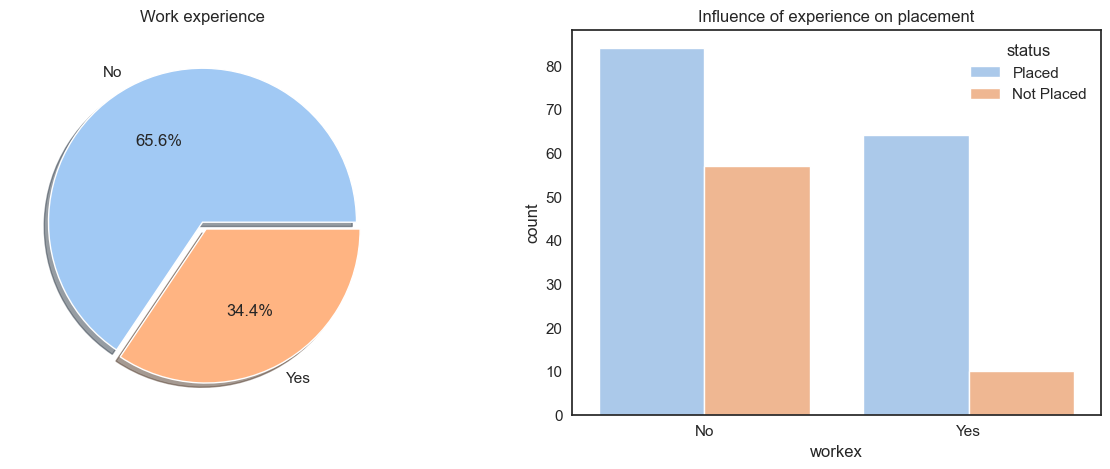

In [483]:
sns.set_palette("pastel")
plt.style.use('seaborn-white')
f, ax = plt.subplots(1, 2, figsize=(15, 5))

df_train['workex'].value_counts().plot.pie(explode=[0, 0.05], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Work experience')
ax[0].set_ylabel('')  # Hides the ylabel for the pie chart

sns.countplot(x='workex', hue='status', data=df_train, ax=ax[1])
ax[1].set_title('Influence of experience on placement')

plt.show()

- We have nearly 65.6% of candidates who never had any work experience.
- Candidates who never had work experience have got hired more than the ones who had experience.
- We can conclude that work experience doesn't influence a candidate in the recruitment process.

In [484]:
df_train.head(5)

,gender,ssc_p,hsc_p,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,0,67.00,91.00,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,0,79.33,78.33,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,0,65.00,68.00,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,0,56.00,52.00,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,0.0
4,0,85.80,73.60,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


In [485]:
# Display the uniques values or categorical values
print(f'Unique values of df_train {df_train.hsc_s.unique()}')
print(f'Unique values of degree_t {df_train.degree_t.unique()}')

Unique values of df_train ['Commerce' 'Science' 'Arts']
Unique values of degree_t ['Sci&Tech' 'Comm&Mgmt' 'Others']


### Label Encoding and One hot encoding
Created two functions for encoding with parameters: 'df' for the dataframe and 'dict' for the list of features to encode:

- binary_encode(df, dict)
- onehot_encode(df, dict)

In [486]:
# Make copy to avoid changing original data 
object_cols=['gender','workex','specialisation','status']

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in object_cols:
    df_train[col] = label_encoder.fit_transform(df_train[col])
df_train.head()


,gender,ssc_p,hsc_p,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,0,67.00,91.00,Commerce,58.00,Sci&Tech,0,55.0,1,58.80,1,270000.0
1,0,79.33,78.33,Science,77.48,Sci&Tech,1,86.5,0,66.28,1,200000.0
2,0,65.00,68.00,Arts,64.00,Comm&Mgmt,0,75.0,0,57.80,1,250000.0
3,0,56.00,52.00,Science,52.00,Sci&Tech,0,66.0,1,59.43,0,0.0
4,0,85.80,73.60,Commerce,73.30,Comm&Mgmt,0,96.8,0,55.50,1,425000.0


In [487]:
dummy_hsc_s=pd.get_dummies(df_train['hsc_s'], prefix='d')
dummy_degree_t=pd.get_dummies(df_train['degree_t'], prefix='d')
df_coded = pd.concat([df_train,dummy_hsc_s,dummy_degree_t],axis=1)
df_coded.drop(['hsc_s','degree_t','salary'],axis=1, inplace=True)
df_coded.head()

,gender,ssc_p,hsc_p,degree_p,workex,etest_p,specialisation,mba_p,status,d_Arts,d_Commerce,d_Science,d_Comm&Mgmt,d_Others,d_Sci&Tech
0,0,67.00,91.00,58.00,0,55.0,1,58.80,1,False,True,False,False,False,True
1,0,79.33,78.33,77.48,1,86.5,0,66.28,1,False,False,True,False,False,True
2,0,65.00,68.00,64.00,0,75.0,0,57.80,1,True,False,False,True,False,False
3,0,56.00,52.00,52.00,0,66.0,1,59.43,0,False,False,True,False,False,True
4,0,85.80,73.60,73.30,0,96.8,0,55.50,1,False,True,False,True,False,False


In [488]:
df_train_new = df_coded.copy()

In [489]:
# Split X and y
X=df_train_new.drop(['status'],axis=1)
y=df_train_new.status


In [490]:
 # Train-test split 80% of training and 20% of training
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.7,random_state=42)
X_train.shape, X_test.shape, y_train.shape,y_test.shape

((150, 14), (65, 14), (150,), (65,))

## Model Training

### Logistic Regression

In [491]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.85


### Evaluation Metrics - Confusion Matrix and Classification Report

In [492]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n",confusion_matrix)
print("Classification Report:\n",classification_report(y_test, y_pred))

Confusion Matrix:
 [[15  6]
 [ 4 40]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.71      0.75        21
           1       0.87      0.91      0.89        44

    accuracy                           0.85        65
   macro avg       0.83      0.81      0.82        65
weighted avg       0.84      0.85      0.84        65



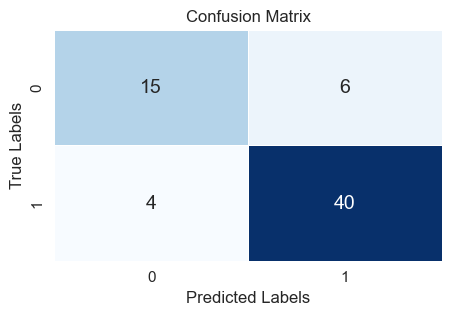

In [493]:
# Plotting confusion matrix
plt.figure(figsize=(5, 3))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d', cbar=False,
            annot_kws={'size': 14}, linewidths=0.5)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


The Confusion matrix result 55 correct predictions (40 + 15) and 10 incorrect predictions (4 + 6) which give as 85% precision which means the accuracy that the model classifier not to label an instance positive that is actually negative and it is important to consider precision value. In hiring, a false positive is when you think an employee is a good fit, but in actuality they’re not.

In Logistic Regression, achieved an accuracy of 85% on the test set, with precision and recall metrics indicating effective identification of placed students.

### ROC Curve

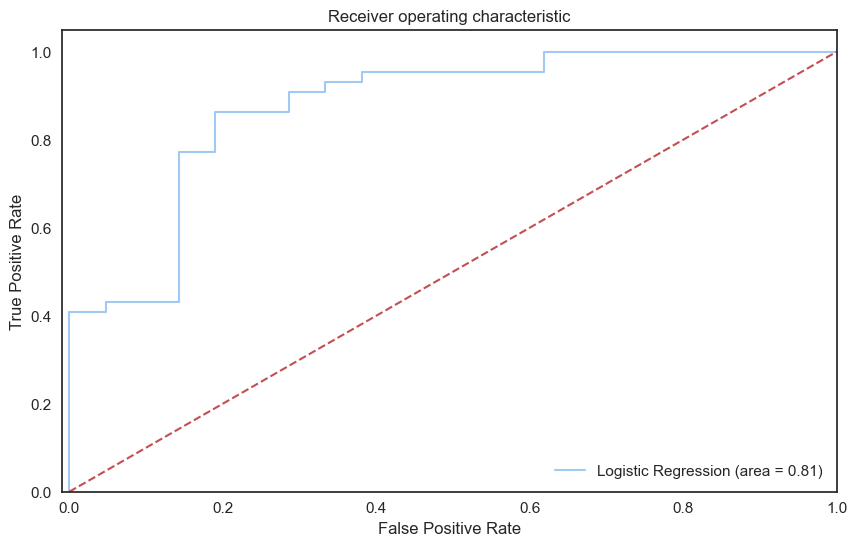

In [494]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

The ROC curve suggests that our logistic model effectively distinguishes placed students from others without many false positives. A ROC curve that leans towards the top-left corner indicates superior model performance. Choosing a threshold value of 0.8 or 0.9 can maximize true positive results.

### Decision Tree

In [495]:
dt = DecisionTreeClassifier(criterion="gini", max_depth=3)
dt = dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8153846153846154


Result give us 81.5% accurate with using gini index as criterion. 

### Random Forest

In [496]:
rt=RandomForestClassifier(n_estimators=100)
rt.fit(X_train,y_train)
y_pred=rt.predict(X_test)

print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.7846153846153846


### Evaluation Metrics - Confusion Matrix and Classification Report

In [497]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier 

conf_matrix_rf = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix_rf)
print("Classification Report:\n",classification_report(y_test, y_pred))

Confusion Matrix:
 [[ 9 12]
 [ 2 42]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.43      0.56        21
           1       0.78      0.95      0.86        44

    accuracy                           0.78        65
   macro avg       0.80      0.69      0.71        65
weighted avg       0.79      0.78      0.76        65



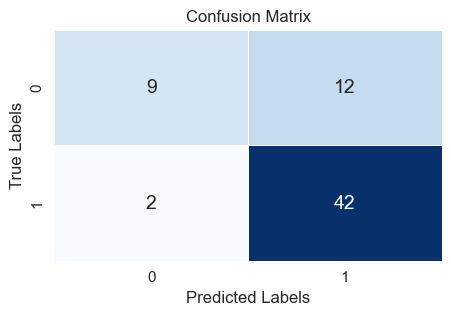

In [498]:
# Plotting confusion matrix
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix_rf, annot=True, cmap='Blues', fmt='d', cbar=False,
            annot_kws={'size': 14}, linewidths=0.5)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Result give us 80% accurate for random forest.

### Feature Importance

Text(0.5, 1.0, 'Visualizing Important Features')

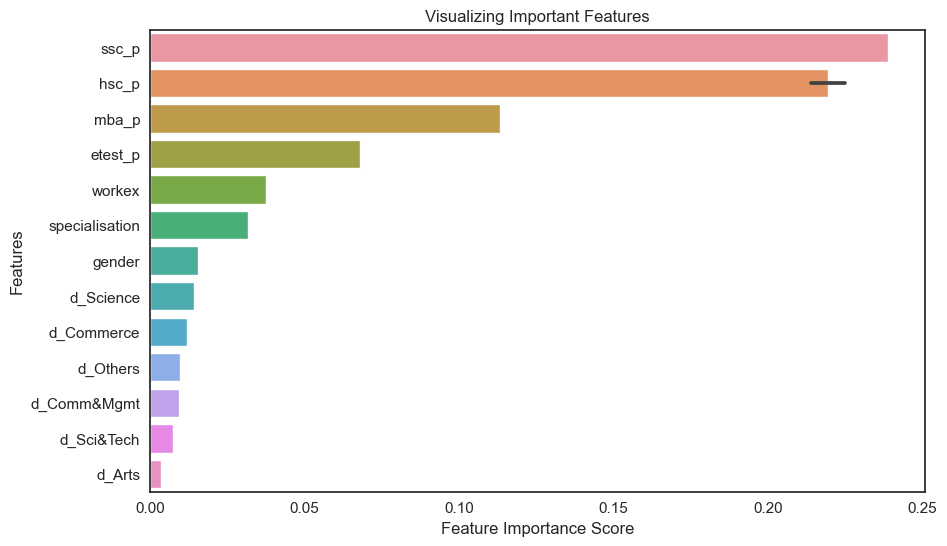

In [499]:
feature_cols=['gender','ssc_p','hsc_p','hsc_p','workex','etest_p','specialisation','mba_p',
              'd_Arts','d_Commerce','d_Science','d_Comm&Mgmt','d_Others','d_Sci&Tech']

feature_imp = pd.Series(rt.feature_importances_,index=feature_cols).sort_values(ascending=False)
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

While school and undergraduate specializations show minimal influence on model classification, it's notable that SSC percentage (ssc_p) significantly impacts classification outcomes.

### Pruning out less important feature

In [500]:
X=df_train_new.drop(['status','d_Comm&Mgmt','d_Sci&Tech','d_Science','d_Commerce',
                        'd_Arts','d_Others'],axis=1)
y=df_train_new.status
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.7,random_state=1)
rt2=RandomForestClassifier(n_estimators=100)
rt2.fit(X_train,y_train)
y_pred=rt2.predict(X_test)
print("Accuracy:",accuracy_score(y_test, y_pred))
roc_value = roc_auc_score(y_test, y_pred)
roc_value
print("ROC Value:",roc_value)

Accuracy: 0.8615384615384616
ROC Value: 0.8027777777777778


In Random Forest, initially achieved 80% accuracy, which improved to 86.15% after feature selection. This model effectively handles complex interactions in the data.

We have an accuracy of 86% and the ROC value 80% indicates the models have classified better without having much false positive predictions.

### Support Vector Machine

In [501]:
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(X_test)
confusion_matrix = confusion_matrix(y_test,y_pred)
print("Confusion Matrix:\n",confusion_matrix)
print("Classification Report:\n",classification_report(y_test,y_pred))

Confusion Matrix:
 [[17  3]
 [ 1 44]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.85      0.89        20
           1       0.94      0.98      0.96        45

    accuracy                           0.94        65
   macro avg       0.94      0.91      0.93        65
weighted avg       0.94      0.94      0.94        65



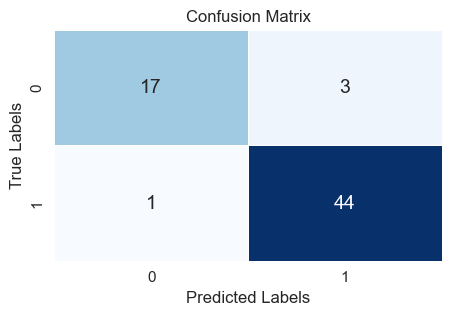

In [502]:
# Plotting confusion matrix
plt.figure(figsize=(5, 3))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d', cbar=False,
            annot_kws={'size': 14}, linewidths=0.5)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

17+44 correctly classified and 1+3 wrongly classified( False Negative & False Positive)

Support Vector Machine (SVM), demonstrated the highest accuracy of 94%, showcasing its robustness in accurately predicting student placement.

### Voting Classifier

In [419]:
lr_clf = LogisticRegression()
rf_clf = RandomForestClassifier()
svm_clf = SVC()

In [420]:

ensemble_clf = VotingClassifier(estimators=[('log_reg', lr_clf),    ("random forest clf",rf_clf), ("support vect clf",svm_clf)])

In [421]:
ensemble_clf

VotingClassifier(estimators=[('log_reg', LogisticRegression()),
                             ('random forest clf', RandomForestClassifier()),
                             ('support vect clf', SVC())])

In [422]:
ensemble_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('log_reg', LogisticRegression()),
                             ('random forest clf', RandomForestClassifier()),
                             ('support vect clf', SVC())])

In [423]:
y_pred = ensemble_clf.predict(X_test)

In [424]:
accuracy_score(y_test, y_pred)

0.8615384615384616

86% of the samples in your y_test were correctly predicted using voting classifier

 All three models : Logistic Regression, Random Forest and Support Vector Machine, have shown strong performance in predicting student placement based on the dataset attributes. 
 - Logistic Regression offers simplicity and interpretability.
 - Random Forest excels in capturing complex interactions.
 - SVM perform exceptionally well in high-dimensional feature spaces. 


 The choice of model can be tailored based on specific priorities, such as model interpretability versus raw predictive accuracy. Each model's hyperparameters were carefully tuned to optimize performance metrics, ensuring robust and reliable predictions for the task at hand.